Processing files...
Processing Jericho Brown
(Original): 5 poems
Processing GPT-4
(Brown Rules): 129 poems
Processing GPT-4
(Original): 129 poems
Processing GPT-4o Mini
(Brown Rules): 129 poems
Processing GPT-4o Mini
(Original): 129 poems
Processing Claude 3.5 Sonnet
(Brown Rules): 129 poems
Processing Claude 3.5 Sonnet
(Original): 129 poems
Processing Olmo 7B
(Brown Rules): 115 poems
Processing Olmo 7B
(Original): 129 poems
Analysis complete. Graph saved to 'syllable_meter_rhyme_plots.png'

 DETAILED POEM ANALYSIS REPORT

--- SOURCE: Jericho Brown (Original) ---
  [Syllables per Line Statistics]
    Min: 8 | Max: 11
    Mean: 9.83
    Mode: 9
    Quantiles:
      25%: 9.0
      50% (Median): 10.0
      75%: 11.0
  [Poem Level Statistics]
    Avg Rhyme Density:    91.4%
    Top Meters:           Free/Irregular (5)
  [Top 5 Rhyme Schemes]
    2   (40.0%): A-B-B-C-C-D-D-E-E-F-F-G-G-A
    1   (20.0%): A-B-B-C-C-D-D-E-F-G-G-H-H-A
    1   (20.0%): A-A-A-B-B-C-C-D-D-E-F-G-G-A
    1   (20.0%)

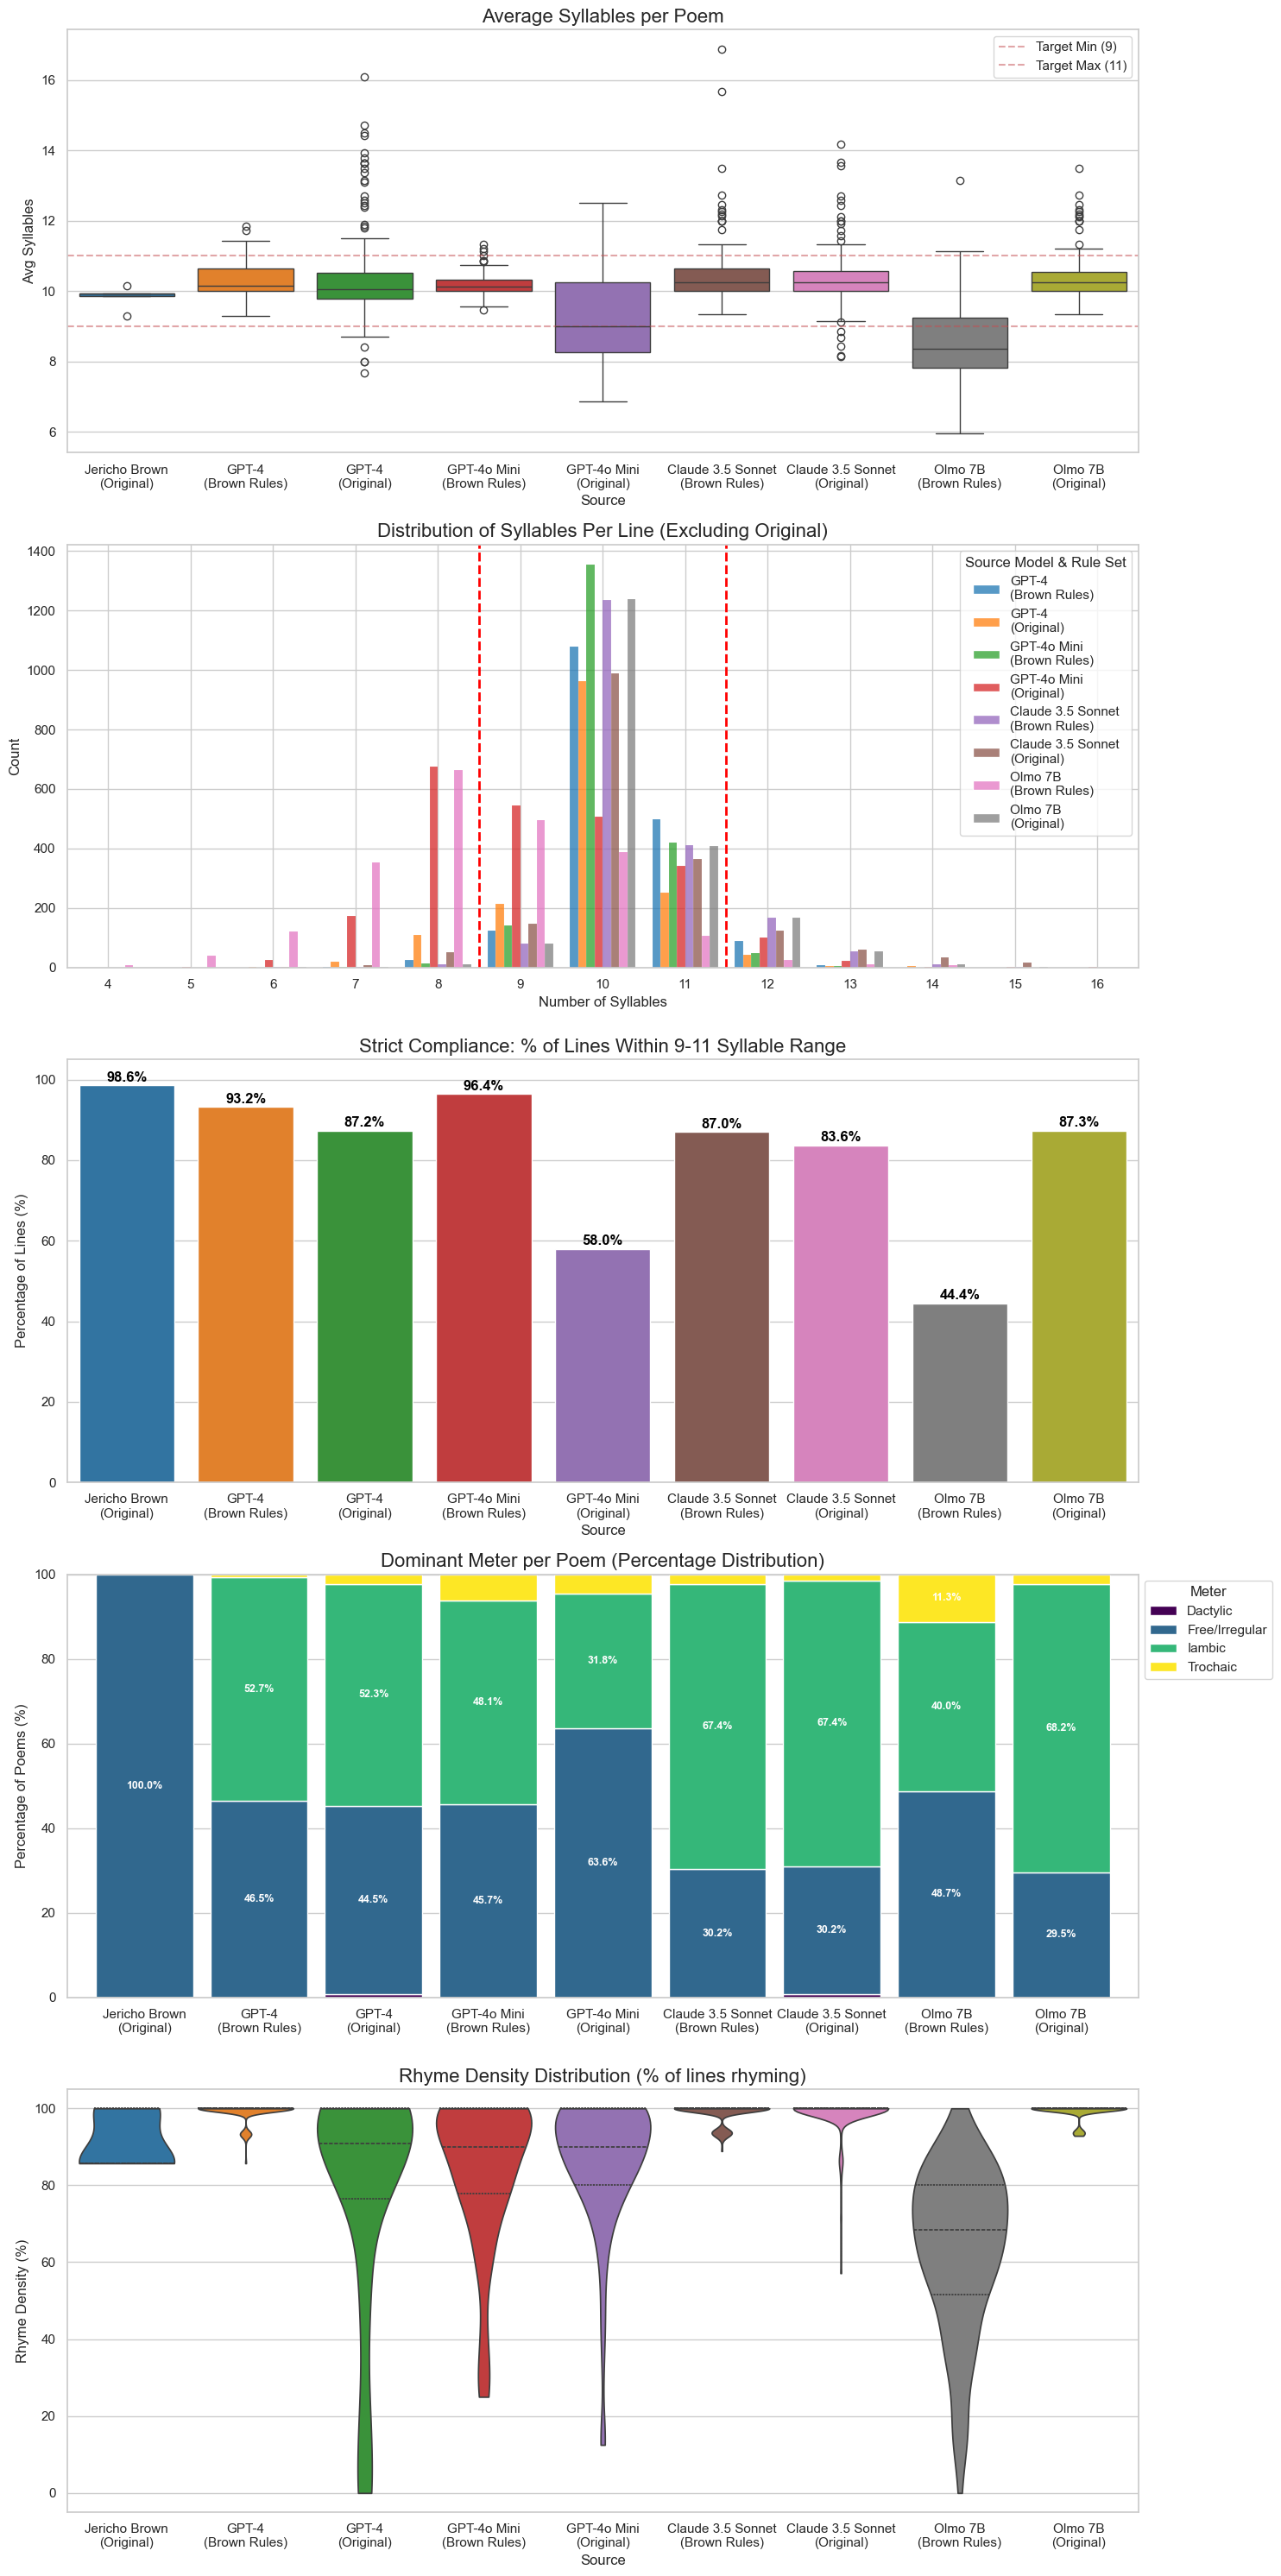

In [ ]:
import pandas as pd
import pronouncing
import string
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from collections import Counter
import warnings
import unicodedata
warnings.filterwarnings("ignore")

# --- Configuration ---
# Baseline file
BASELINE_FILE = ("original_brown_duplexes.csv", "Jericho Brown", "Original")

# Data files to process
DATA_FILES = [
    ("GPT4_all_poems_clean.csv", "GPT-4"),
    ("4o_mini_all_poems_clean.csv", "GPT-4o Mini"),
    ("claude_all_poems_clean.csv", "Claude 3.5 Sonnet"),
    ("olmo_all_poems_clean.csv", "Olmo 7B")
]

# --- Improved Helper Functions ---

def clean_word(word):
    """
    Improved word cleaning that handles:
    1. Unicode dashes (em-dash, en-dash, etc.)
    2. Hyphenated compound words
    """
    # First, normalize Unicode characters
    word = unicodedata.normalize('NFKD', word)
    
    # Define extended punctuation including Unicode dashes
    # U+2014 = em dash (—), U+2013 = en dash (–)
    extended_punctuation = string.punctuation + '—–""''…'
    
    # Remove all punctuation
    translator = str.maketrans('', '', extended_punctuation)
    cleaned = word.translate(translator).lower()
    
    # If the word is empty after cleaning, return empty string
    if not cleaned:
        return ""
    
    return cleaned

def get_rhyme_word(word):
    """
    Extract the rhyming component from a word.
    For hyphenated compounds like 'hand-in-hand', takes the last component.
    """
    # Clean the word first
    cleaned = clean_word(word)
    
    if not cleaned:
        return ""
    
    # If the original word contained hyphens, try the last component
    # (before punctuation was removed)
    if '-' in word:
        # Split on hyphen and take the last part
        parts = word.split('-')
        last_part = clean_word(parts[-1])
        
        # Try the last component first
        if pronouncing.phones_for_word(last_part):
            return last_part
    
    # Otherwise return the fully cleaned word
    return cleaned

def get_line_stats(line):
    """Returns (stress_pattern, syllable_count) for a single line."""
    words = line.split()
    pattern = ""
    count = 0
    
    for word in words:
        cleaned = clean_word(word)
        
        if not cleaned:
            continue
            
        pronunciations = pronouncing.phones_for_word(cleaned)
        if pronunciations:
            phones = pronunciations[0]
            pattern += pronouncing.stresses(phones)
            count += pronouncing.syllable_count(phones)
        else:
            # Fallback for unknown words: try last component if hyphenated
            if '-' in word:
                last_part = clean_word(word.split('-')[-1])
                pronunciations = pronouncing.phones_for_word(last_part)
                if pronunciations:
                    phones = pronunciations[0]
                    pattern += pronouncing.stresses(phones)
                    count += pronouncing.syllable_count(phones)
                    continue
            
            # Still unknown - use simple fallback
            count += 1
            pattern += "0"
            
    return pattern, count

def identify_meter(pattern):
    """Identifies the dominant foot in a stress pattern."""
    if not pattern: return "Empty"
    pattern = pattern.replace("2", "1")
    
    feet = {
        "Iambic": "01", "Trochaic": "10", 
        "Anapestic": "001", "Dactylic": "100"
    }
    
    best_meter = "Free/Irregular"
    best_score = 0.0
    
    for name, foot in feet.items():
        target = (foot * (len(pattern)//len(foot) + 1))[:len(pattern)]
        matches = sum(1 for i, c in enumerate(pattern) if c == target[i])
        score = matches / len(pattern) if len(pattern) > 0 else 0
        
        if score > best_score:
            best_score = score
            best_meter = name
            
    if best_score < 0.70: return "Free/Irregular"
    return best_meter

def get_rhyme_density(lines):
    """
    Calculates % of lines that end with a rhyming word.
    Improved to handle em-dashes and compound words.
    """
    # Extract end words using improved function
    end_words = []
    for line in lines:
        words = line.split()
        if words:
            rhyme_word = get_rhyme_word(words[-1])
            end_words.append(rhyme_word)
        else:
            end_words.append("")
    
    if not end_words:
        return 0.0
    
    rhyme_hits = 0
    total = len(end_words)
    
    for i, word in enumerate(end_words):
        if not word:
            continue
            
        has_rhyme = False
        word_rhymes = pronouncing.rhymes(word)
        
        for j, other in enumerate(end_words):
            if i == j or not other:
                continue
                
            # Check for exact match or rhyme
            if word == other or other in word_rhymes or word in pronouncing.rhymes(other):
                has_rhyme = True
                break
                
        if has_rhyme:
            rhyme_hits += 1
            
    return (rhyme_hits / total) * 100

def get_rhyme_scheme_string(lines):
    """
    Generates a rhyme scheme string (e.g., 'A-A-B-B').
    Improved to handle em-dashes and compound words.
    """
    # Extract end words using improved function
    end_words = []
    for line in lines:
        words = line.split()
        if words:
            rhyme_word = get_rhyme_word(words[-1])
            end_words.append(rhyme_word)
        else:
            end_words.append("")
    
    scheme = []
    unique_rhymes = {}  # Maps representative word -> Character
    next_char_idx = 0
    
    for word in end_words:
        if not word:
            scheme.append("?")
            continue
            
        found_char = None
        
        # Check against known rhyme groups
        for rep_word, char in unique_rhymes.items():
            if word == rep_word or word in pronouncing.rhymes(rep_word) or rep_word in pronouncing.rhymes(word):
                found_char = char
                break
        
        if found_char:
            scheme.append(found_char)
        else:
            # New rhyme sound
            if next_char_idx < 26:
                char = chr(65 + next_char_idx)
            else:
                char = chr(65 + (next_char_idx % 26)) + str(next_char_idx // 26)
            
            unique_rhymes[word] = char
            scheme.append(char)
            next_char_idx += 1
            
    return "-".join(scheme)

# --- Analysis Function ---

def analyze_poems(df, source_label, line_data_list, poem_data_list):
    """Analyzes poems in a dataframe and appends results to data lists."""
    print(f"Processing {source_label}: {len(df)} poems")
    
    for text in df['poem_text']:
        if not isinstance(text, str): continue
        
        lines = [l.strip() for l in text.split('\n') if l.strip()]
        if not lines: continue
        
        poem_meters = []
        poem_syl_counts = []
        
        # Analyze each line
        for line in lines:
            pattern, syl_count = get_line_stats(line)
            meter = identify_meter(pattern)
            poem_meters.append(meter)
            poem_syl_counts.append(syl_count)
            
            # Store Line Data
            line_data_list.append({
                "Source": source_label,
                "Syllables": syl_count,
                "Meter": meter
            })
        
        # Store Poem Data
        dom_meter = Counter(poem_meters).most_common(1)[0][0] if poem_meters else "None"
        rhyme_dens = get_rhyme_density(lines)
        avg_syl = sum(poem_syl_counts) / len(poem_syl_counts) if poem_syl_counts else 0
        rhyme_scheme_str = get_rhyme_scheme_string(lines)
        
        poem_data_list.append({
            "Source": source_label,
            "Dominant_Meter": dom_meter,
            "Rhyme_Density": rhyme_dens,
            "Avg_Syllables": avg_syl,
            "Rhyme_Scheme": rhyme_scheme_str
        })

# --- Main Processing Loop ---

line_data = []  # Stores one row per LINE
poem_data = []  # Stores one row per POEM
desired_order = []  # To keep track of plot order

print("Processing files...")

# 1. Process Baseline (Jericho Brown)
try:
    fname, model_name, rule_set = BASELINE_FILE
    df = pd.read_csv(fname)
    if 'poem_text' in df.columns:
        label = f"{model_name}\n({rule_set})"
        desired_order.append(label)
        analyze_poems(df, label, line_data, poem_data)
    else:
        print(f"Skipping {fname}: 'poem_text' column not found.")
except Exception as e:
    print(f"Skipping baseline file {fname}: {e}")

# 2. Process Model Files (Split by with_brown_rules or with_brown)
for fname, model_name in DATA_FILES:
    try:
        if fname.endswith('.csv'):
            df = pd.read_csv(fname)
        else:
            df = pd.read_excel(fname)
            
        if 'poem_text' not in df.columns:
            print(f"Skipping {fname}: 'poem_text' column not found.")
            continue
        
        # Handle both 'with_brown_rules' and 'with_brown' column names
        brown_col = None
        if 'with_brown_rules' in df.columns:
            brown_col = 'with_brown_rules'
        elif 'with_brown' in df.columns:
            brown_col = 'with_brown'
        else:
            print(f"Skipping {fname}: Neither 'with_brown_rules' nor 'with_brown' column found.")
            continue
            
        # Split into two groups
        df_brown = df[df[brown_col] == True]
        df_original = df[df[brown_col] == False]
        
        # Process Brown Rules
        if not df_brown.empty:
            label = f"{model_name}\n(Brown Rules)"
            desired_order.append(label)
            analyze_poems(df_brown, label, line_data, poem_data)
            
        # Process Original Rules
        if not df_original.empty:
            label = f"{model_name}\n(Original)"
            desired_order.append(label)
            analyze_poems(df_original, label, line_data, poem_data)
            
    except Exception as e:
        print(f"Skipping {fname}: {e}")

df_lines = pd.DataFrame(line_data)
df_poems = pd.DataFrame(poem_data)

# Check if we have any data to visualize
if df_lines.empty or df_poems.empty:
    print("\n⚠️  WARNING: No data was successfully processed!")
    exit(1)

# --- Visualization ---

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(5, 1, figsize=(15, 30)) 

# 1. Average Syllables per Poem (Box Plot)
sns.boxplot(x='Source', y='Avg_Syllables', data=df_poems, ax=axes[0], palette="tab10", order=desired_order)
axes[0].axhline(y=9, color='r', linestyle='--', alpha=0.5, label='Target Min (9)')
axes[0].axhline(y=11, color='r', linestyle='--', alpha=0.5, label='Target Max (11)')
axes[0].set_title('Average Syllables per Poem', fontsize=16)
axes[0].set_ylabel('Avg Syllables')
axes[0].legend()

# 2. Syllables per Line (Hist Plot)
plot2_data = df_lines[~df_lines['Source'].str.contains("Jericho Brown")]
plot2_order = [s for s in desired_order if "Jericho Brown" not in s]

sns.histplot(
    data=plot2_data, 
    x='Syllables', 
    hue='Source', 
    multiple="dodge", 
    discrete=True, 
    shrink=0.8, 
    ax=axes[1], 
    palette="tab10",
    hue_order=plot2_order
)
axes[1].set_xlim(left=3.5, right=16.5)
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axes[1].set_xticks(range(4, 17))
axes[1].set_xticklabels(range(4, 17))
axes[1].axvline(x=8.5, color='red', linestyle='--', linewidth=2, label='Min Boundary (8.5)')
axes[1].axvline(x=11.5, color='red', linestyle='--', linewidth=2, label='Max Boundary (11.5)')
axes[1].set_title('Distribution of Syllables Per Line (Excluding Original)', fontsize=16)
axes[1].set_xlabel('Number of Syllables')
sns.move_legend(axes[1], "upper right", title="Source Model & Rule Set")

# 3. Percentage Adherence (Bar Plot)
adherence_stats = []
for source in df_lines['Source'].unique():
    subset = df_lines[df_lines['Source'] == source]
    total = len(subset)
    compliant = len(subset[(subset['Syllables'] >= 9) & (subset['Syllables'] <= 11)])
    pct = (compliant / total) * 100 if total > 0 else 0
    adherence_stats.append({'Source': source, 'Pct_Compliant': pct})

df_adherence = pd.DataFrame(adherence_stats)

sns.barplot(x='Source', y='Pct_Compliant', data=df_adherence, ax=axes[2], palette="tab10", order=desired_order)
axes[2].set_title('Strict Compliance: % of Lines Within 9-11 Syllable Range', fontsize=16)
axes[2].set_ylabel('Percentage of Lines (%)')
axes[2].set_ylim(0, 105)
for index, row in df_adherence.iterrows():
    try:
        x_pos = desired_order.index(row.Source)
        axes[2].text(x_pos, row.Pct_Compliant + 1, f"{row.Pct_Compliant:.1f}%", color='black', ha="center", fontweight='bold')
    except ValueError:
        pass 

# 4. Dominant Meter (Stacked Bar Chart)
meter_counts = df_poems.groupby(['Source', 'Dominant_Meter']).size().reset_index(name='Count')
source_totals = df_poems.groupby('Source').size().reset_index(name='Total')
meter_data = pd.merge(meter_counts, source_totals, on='Source')
meter_data['Percentage'] = (meter_data['Count'] / meter_data['Total']) * 100

pivot_df = meter_data.pivot(index='Source', columns='Dominant_Meter', values='Percentage').fillna(0)
pivot_df = pivot_df.reindex(desired_order)

pivot_df.plot(kind='bar', stacked=True, ax=axes[3], colormap='viridis', width=0.85)
axes[3].set_title('Dominant Meter per Poem (Percentage Distribution)', fontsize=16)
axes[3].set_ylabel('Percentage of Poems (%)')
axes[3].set_xlabel('')
axes[3].set_ylim(0, 100)
axes[3].legend(title='Meter', bbox_to_anchor=(1.0, 1.0), loc='upper left')
axes[3].tick_params(axis='x', rotation=0)

for c in axes[3].containers:
    labels = [f'{v.get_height():.1f}%' if v.get_height() > 8 else '' for v in c]
    axes[3].bar_label(c, labels=labels, label_type='center', color='white', fontweight='bold', fontsize=9)

# 5. Rhyme Density (Violin Plot)
sns.violinplot(x='Source', y='Rhyme_Density', data=df_poems, ax=axes[4], palette="tab10", inner="quartile", cut=0, order=desired_order)
axes[4].set_title('Rhyme Density Distribution (% of lines rhyming)', fontsize=16)
axes[4].set_ylabel('Rhyme Density (%)')

plt.tight_layout()
plt.savefig('syllable_meter_rhyme_plots.png')
print("Analysis complete. Graph saved to 'syllable_meter_rhyme_plots.png'")

# --- Text Summary Statistics ---
print("\n" + "="*70)
print(" DETAILED POEM ANALYSIS REPORT")
print("="*70)

grouped = df_poems.groupby('Source')

for name in desired_order:
    if name not in grouped.groups: continue
    group = grouped.get_group(name)
    
    print(f"\n--- SOURCE: {name.replace(chr(10), ' ')} ---")
    
    line_subset = df_lines[df_lines['Source'] == name]['Syllables']
    print(f"  [Syllables per Line Statistics]")
    print(f"    Min: {line_subset.min()} | Max: {line_subset.max()}")
    print(f"    Mean: {line_subset.mean():.2f}")
    
    modes = line_subset.mode()
    mode_str = ", ".join(map(str, modes.tolist()))
    print(f"    Mode: {mode_str}")
    
    print(f"    Quantiles:")
    print(f"      25%: {line_subset.quantile(0.25)}")
    print(f"      50% (Median): {line_subset.quantile(0.50)}")
    print(f"      75%: {line_subset.quantile(0.75)}")

    print(f"  [Poem Level Statistics]")
    mean_rd = group['Rhyme_Density'].mean()
    print(f"    Avg Rhyme Density:    {mean_rd:.1f}%")
    
    top_meters = group['Dominant_Meter'].value_counts().head(3)
    meters_str = ", ".join([f"{m} ({c})" for m, c in top_meters.items()])
    print(f"    Top Meters:           {meters_str}")
    
    print(f"  [Top 5 Rhyme Schemes]")
    top_schemes = group['Rhyme_Scheme'].value_counts().head(5)
    for scheme, count in top_schemes.items():
        pct = (count / len(group)) * 100
        print(f"    {count:<3} ({pct:.1f}%): {scheme}")